In [4]:
pip install yfinance numpy pandas matplotlib scikit-learn tensorflow -q

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Baixar dados
ticker = "PETR4.SA"
df = yf.download(ticker, start="2007-01-01")
df

C:\Users\bielm\AppData\Local\Temp\ipykernel_13968\3071886060.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2007-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,
2007-01-02,5.287380,5.301040,5.228538,5.253756,10244800
2007-01-03,5.126616,5.295787,5.044657,5.270569,19898600
2007-01-04,5.012084,5.122412,4.980561,5.096144,21060200
2007-01-05,4.859725,5.042556,4.738889,4.959547,24864000
2007-01-08,4.916464,4.953240,4.812440,4.885992,19440200
...,...,...,...,...,...
2025-12-08,31.660000,31.990000,31.490000,31.570000,30271600
2025-12-09,31.860001,31.900000,31.330000,31.610001,23863000


In [ ]:


# Usar apenas o Fechamento Ajustado ('Adj Close')
data = df[['Close']].values

# Normalização (0 a 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Criar Janela Deslizante 
lags = 5
X, y = [], []

for i in range(lags, len(data_scaled)):
    X.append(data_scaled[i-lags:i, 0])
    y.append(data_scaled[i, 0])

X, y = np.array(X), np.array(y)

# Reshape para 3D [Amostras, Passos de Tempo, Features] (Exigência da LSTM)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [33]:
# ==============================================================================
# 3. SEPARAÇÃO TREINO E TESTE
# ==============================================================================
# Reservar os últimos 30 dias para teste (igual ao R)
test_days = 5

X_train = X[:-test_days]
y_train = y[:-test_days]
X_test  = X[-test_days:]
y_test  = y[-test_days:]

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (4601, 100, 1), Teste: (5, 100, 1)


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
# ==============================================================================
# 4. MODELAGEM LSTM (OTIMIZADA)
# ==============================================================================
model = Sequential()

# Aumentei para 100 neurônios e adicionei mais uma camada para ver se captura melhor
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# Learning Rate menor para aprender com mais calma
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# --- CALLBACKS (O Segredo do Sucesso) ---
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

print("Iniciando treinamento otimizado...")
# Usamos 10% do treino para validação interna
history = model.fit(X_train, y_train, 
                    epochs=150, # Damos bastante tempo
                    batch_size=32, 
                    validation_split=0.1, # Importante para os callbacks
                    callbacks=[es, rlr],
                    verbose=1)

Iniciando treinamento otimizado...
Epoch 1/150


c:\Users\bielm\AppData\Local\r-miniconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0025 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 2/150
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 6.2843e-04 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 3/150
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 5.5775e-04 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/150
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 5.2052e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 5/150
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 4.9072e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 6/150
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 4.8930e-04 - val_loss: 9.4699e-04 - learning_rate: 0.0010
Epoch 7/150
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 3.8373e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 8/150
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 4.1229e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 9/150
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 3.6783e-04 - val_loss:

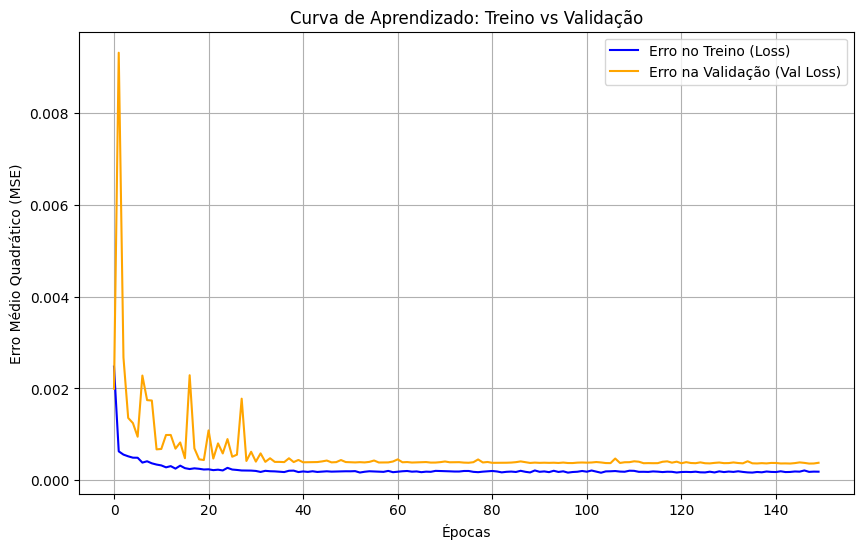

In [37]:
# ==============================================================================
# GRÁFICO DE DIAGNÓSTICO (LOSS)
# ==============================================================================
plt.figure(figsize=(10, 6))

# Linha de Treino (Azul)
plt.plot(history.history['loss'], label='Erro no Treino (Loss)', color='blue')

# Linha de Validação (Laranja) - A MAIS IMPORTANTE
plt.plot(history.history['val_loss'], label='Erro na Validação (Val Loss)', color='orange')

plt.title('Curva de Aprendizado: Treino vs Validação')
plt.xlabel('Épocas')
plt.ylabel('Erro Médio Quadrático (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# ==============================================================================
# 5. PREVISÃO E AVALIAÇÃO
# ==============================================================================
# Prever
predictions_scaled = model.predict(X_test)

# Desnormalizar (Voltar para R$)
predictions = scaler.inverse_transform(predictions_scaled)
real_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular Erros
rmse = np.sqrt(np.mean(((predictions - real_values) ** 2)))
mape = np.mean(np.abs((real_values - predictions) / real_values)) * 100

print("\n================ RESULTADOS LSTM ================")
print(f"RMSE: R$ {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print("=================================================")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

================ RESULTADOS LSTM ================
RMSE: R$ 0.3961
MAPE: 1.0707%


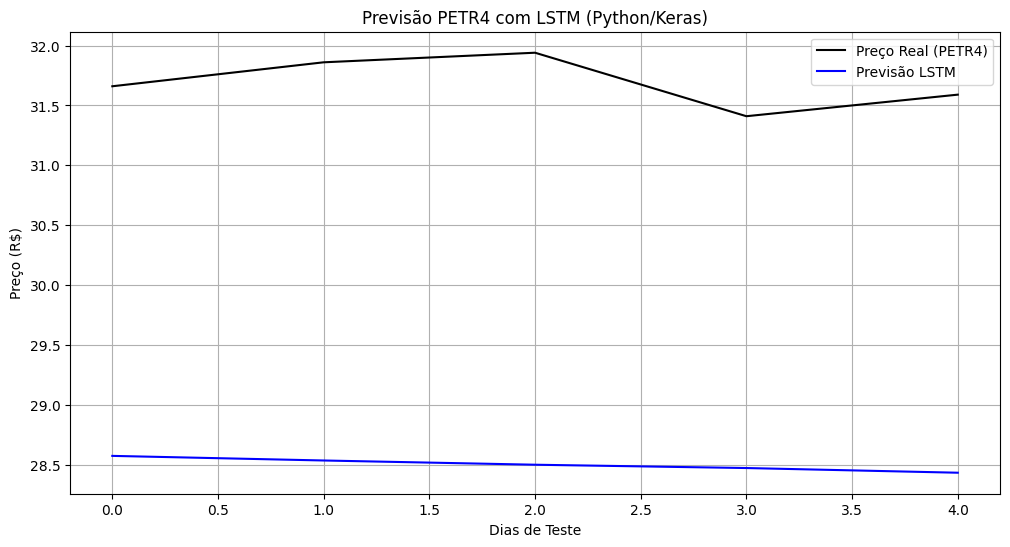

In [20]:
# ==============================================================================
# 6. GRÁFICO
# ==============================================================================
plt.figure(figsize=(12, 6))
plt.plot(real_values, color='black', label='Preço Real (PETR4)')
plt.plot(predictions, color='blue', label='Previsão LSTM')
plt.title('Previsão PETR4 com LSTM (Python/Keras)')
plt.xlabel('Dias de Teste')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
df_resultado = pd.DataFrame({
    'Real': real_values.flatten(),
    'Previsto': predictions.flatten(),
    'Erro': abs(real_values.flatten() - predictions.flatten())
})
print(df_resultado.head())

    Real   Previsto      Erro
0  29.75  30.130592  0.380592
1  30.10  30.012682  0.087318
2  30.25  30.069998  0.180002
3  30.85  30.228273  0.621727
4  31.01  30.621651  0.388350
